In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,6)
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics


%matplotlib inline

In [19]:
#load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
train.shape


(1460, 81)

In [21]:
test.shape

(1459, 80)

In [22]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [0]:
train = train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence','Id'], axis=1)

In [24]:
train.shape

(1460, 76)

In [25]:
#stats of the predictor variable (saleprice)
train.SalePrice.describe().round(2)

count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

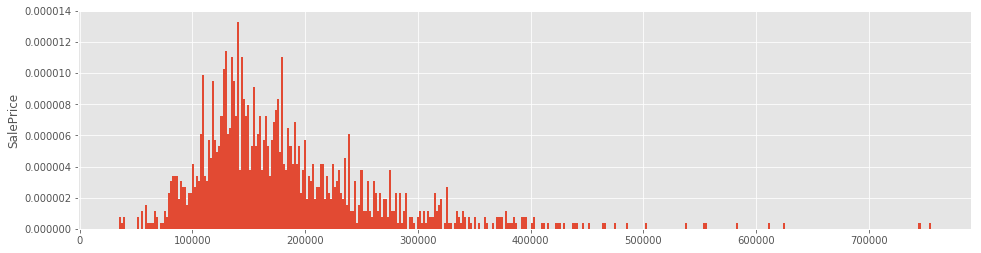

In [26]:
#spotting and removing outliers
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 4.0

x =train['SalePrice']
plt.hist(x, density=True, bins=400)
plt.ylabel('SalePrice');

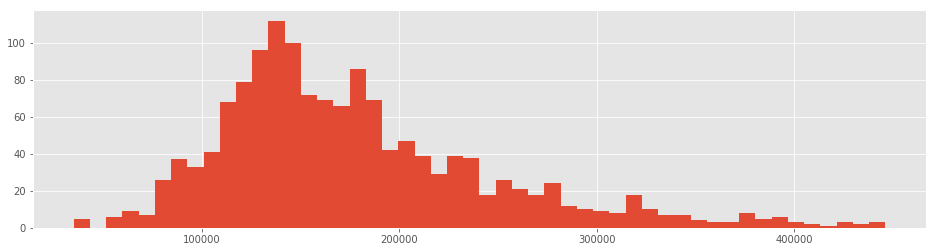

(1446, 1)

In [27]:
##analysing the distribution of sale price
def reject_outliers(SalePrice):
    filtered= [e for e in (train['SalePrice']) if (e < 450000)]
    return filtered

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 4.0

filtered = reject_outliers('SalePrice')
plt.hist(filtered, 50)
fig_size[0]=16.0
fig_size[1]=8.0
plt.show()

df_no_outliers = pd.DataFrame(filtered)
df_no_outliers.shape

In [0]:

train = train[train['SalePrice']<450000]

In [29]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [0]:
X_train = train.drop(['SalePrice'], axis=1)

In [31]:

X_train.shape

(1446, 75)

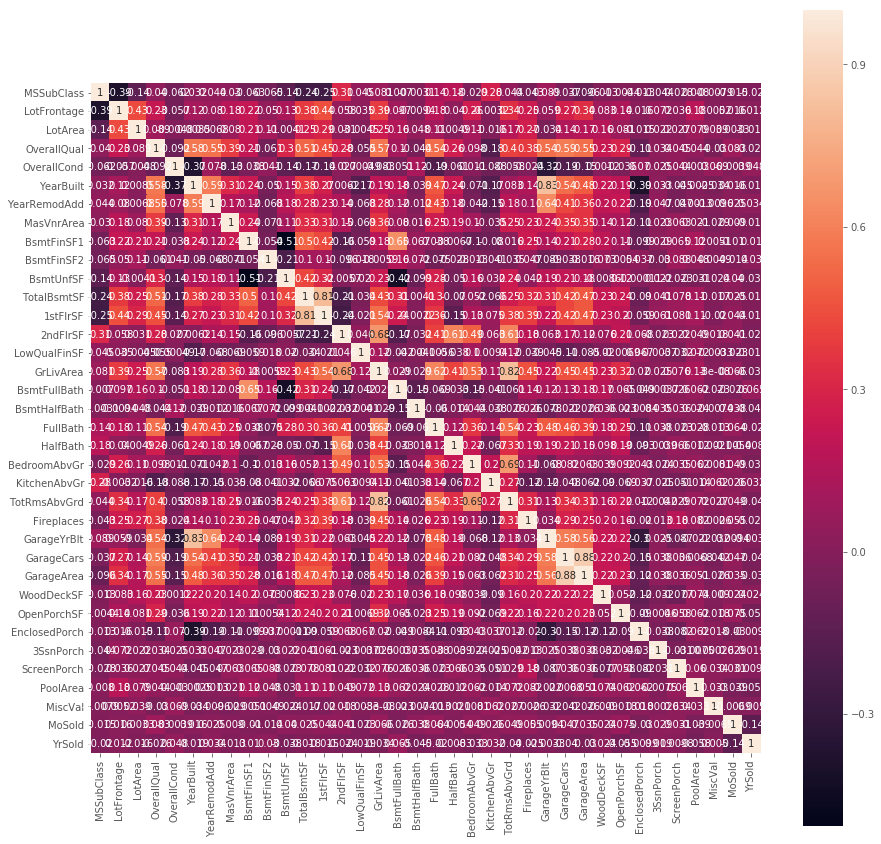

In [32]:
import seaborn as sns
corr_matrix = X_train.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, vmax=1, annot=True, square=True);
plt.show()

In [0]:
y_train = train['SalePrice']

In [34]:
y_train.shape

(1446,)

In [0]:
#y_train.describe()

In [36]:

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1459
Data columns (total 75 columns):
MSSubClass       1446 non-null int64
MSZoning         1446 non-null object
LotFrontage      1188 non-null float64
LotArea          1446 non-null int64
Street           1446 non-null object
LotShape         1446 non-null object
LandContour      1446 non-null object
Utilities        1446 non-null object
LotConfig        1446 non-null object
LandSlope        1446 non-null object
Neighborhood     1446 non-null object
Condition1       1446 non-null object
Condition2       1446 non-null object
BldgType         1446 non-null object
HouseStyle       1446 non-null object
OverallQual      1446 non-null int64
OverallCond      1446 non-null int64
YearBuilt        1446 non-null int64
YearRemodAdd     1446 non-null int64
RoofStyle        1446 non-null object
RoofMatl         1446 non-null object
Exterior1st      1446 non-null object
Exterior2nd      1446 non-null object
MasVnrType       1439 no

In [0]:
#39 categorical values remain, the rest are numerical. These are the categrocial values:
cat_values= ['FireplaceQu','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
             'BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition']

In [0]:

#Missing data now replace by their mean or with categories by the most frequent value in each column.
X_train = X_train.apply(lambda x:x.fillna(x.value_counts().index[0])) #= fills every numercial column with its own most frequent value

X_train = X_train.fillna(X_train['GarageFinish'].value_counts().index[0]) #fill NaNs with the most frequent value from that column.
X_train = X_train.fillna(X_train['BsmtQual'].value_counts().index[0])
X_train = X_train.fillna(X_train['GarageType'].value_counts().index[0])
X_train = X_train.fillna(X_train['GarageQual'].value_counts().index[0])
X_train = X_train.fillna(X_train['GarageCond'].value_counts().index[0])
X_train = X_train.fillna(X_train['BsmtCond'].value_counts().index[0])
X_train = X_train.fillna(X_train['BsmtExposure'].value_counts().index[0])
X_train = X_train.fillna(X_train['BsmtFinType1'].value_counts().index[0])
X_train = X_train.fillna(X_train['FireplaceQu'].value_counts().index[0])

In [0]:
#OneHotEncoder to handle text and categorical attributes.
X_train = pd.get_dummies(X_train, columns=['FireplaceQu','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
                                           'ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition'])  

In [40]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,...,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1446.000000,1446.000000,1446.000000,1446.00000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.00000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,56.995159,67.996542,10426.825726,6.06639,5.577455,1971.030429,1984.684647,98.945367,436.552559,46.627248,564.259336,1047.439142,1153.811895,341.675657,5.505533,1500.993084,0.423237,0.057400,1.556017,0.378285,2.863762,1.047026,6.482019,0.604426,1979.751037,1.755187,469.369295,93.262794,45.937759,22.166667,3.44260,14.527663,2.401798,43.910097,6.331950,2007.815353,0.015906,0.022822,0.733057,0.013831,...,0.009682,0.000692,0.931535,0.004149,0.652144,0.013140,0.057400,0.006224,0.266943,0.236515,0.289765,0.473721,0.001383,0.033195,0.009682,0.002075,0.953665,0.001383,0.024205,0.006224,0.004841,0.963347,0.062241,0.020747,0.917012,0.029737,0.002766,0.001383,0.006224,0.002766,0.003458,0.080221,0.002075,0.871369,0.069156,0.002766,0.008299,0.013831,0.823651,0.082296
std,42.446131,22.138085,9927.254968,1.34695,1.113250,30.114667,20.654418,171.659401,446.360566,161.520020,439.117180,426.356944,376.453129,428.667759,46.528121,501.654786,0.518835,0.238559,0.543577,0.501953,0.812600,0.221355,1.585626,0.639924,24.755809,0.740960,211.343642,124.484376,65.723213,61.376116,29.45708,54.448467,37.664404,498.502039,2.704688,1.326258,0.125155,0.149386,0.442516,0.116831,...,0.097953,0.026298,0.252629,0.064304,0.476455,0.113912,0.232685,0.078674,0.442516,0.425089,0.453810,0.499482,0.037178,0.179207,0.097953,0.045517,0.210282,0.037178,0.153737,0.078674,0.069432,0.187973,0.241676,0.142585,0.275959,0.169920,0.052541,0.037178,0.078674,0.052541,0.058722,0.271729,0.045517,0.334907,0.253808,0.052541,0.090750,0.116831,0.381248,0.274910
min,20.000000,21.000000,1300.000000,1.00000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.

In [41]:
train.SalePrice.describe().round(2)

count      1446.00
mean     177268.66
std       69949.61
min       34900.00
25%      129900.00
50%      162000.00
75%      212000.00
max      446261.00
Name: SalePrice, dtype: float64

In [0]:
X_train = X_train.drop(['Condition2_RRAe',
                        'Exterior2nd_Other','Condition2_RRAn','Condition2_RRNn','HouseStyle_2.5Fin','RoofMatl_ClyTile','RoofMatl_Membran','RoofMatl_Metal','RoofMatl_Roll','Exterior1st_ImStucc','Heating_Floor','Heating_OthW','Electrical_Mix','GarageQual_Ex', 'Exterior1st_Stone','Utilities_NoSeWa'], axis=1)

In [43]:

X_train.shape

(1446, 259)

In [0]:
#df_test=pd.read_csv(test.csv)

In [45]:
test.shape

(1459, 80)

In [46]:

total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


In [0]:

test = test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)

In [48]:
test.shape

(1459, 76)

In [0]:
test = test.apply(lambda x:x.fillna(x.value_counts().index[0])) #= fills every column with its own most frequent value

test = test.fillna(test['GarageFinish'].value_counts().index[0]) #fill NaNs with the most frequent value from that column.
test = test.fillna(test['BsmtQual'].value_counts().index[0])
test = test.fillna(test['FireplaceQu'].value_counts().index[0])
test = test.fillna(test['GarageType'].value_counts().index[0])
test = test.fillna(test['GarageQual'].value_counts().index[0])
test = test.fillna(test['GarageCond'].value_counts().index[0])
test = test.fillna(test['GarageFinish'].value_counts().index[0])
test = test.fillna(test['BsmtCond'].value_counts().index[0])
test = test.fillna(test['BsmtExposure'].value_counts().index[0])
test = test.fillna(test['BsmtFinType1'].value_counts().index[0])
test = test.fillna(test['BsmtFinType2'].value_counts().index[0])
test = test.fillna(test['BsmtUnfSF'].value_counts().index[0])

In [0]:
test = pd.get_dummies(test, columns=['FireplaceQu','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',
                                        'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition'])

In [51]:
test.shape

(1459, 260)

In [52]:
test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,...,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,0,0,1,...,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,0,0,1,...,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,0,0,0,...,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,6,2010,0,0,1,...,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,1,2010,0,0,1,...,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [0]:
test = test.drop(['Id'], axis=1)

In [54]:
test.shape

(1459, 259)

In [0]:
from xgboost import XGBRegressor

In [56]:
xgb_clf = XGBRegressor(n_estimators=1000, learning_rate=0.05)

xgb_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [57]:

xgb_predictions_test = xgb_clf.predict(test) # shape(1459, 262)

xgb_predictions_test

array([122130.336, 162974.27 , 186210.31 , ..., 151103.97 , 120057.55 ,
       227699.48 ], dtype=float32)

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

In [0]:
est = GradientBoostingRegressor(n_estimators= 1000, max_depth= 2, learning_rate= .01)
model=est.fit(X_train, y_train)

In [0]:
y_train_predict = est.predict(X_train)

In [0]:
y_test_predict = est.predict(test)

In [0]:
predictions = model.predict(test)